### Import Package

In [91]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from stockstats import StockDataFrame

from sklearn.model_selection import train_test_split
from sklearn import linear_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from math import floor

### Set the data source path

In [92]:
# Set the data source path
interval = "daily"
region = "us"
ex_product = "nasdaq stocks"
section = "1"
stock = "aapl"
data_path = "test_data/"+interval+"/"+region+"/"+ex_product+"/"+section+"/"+stock+"."+region+".txt"

# Use Apple .Inc stock for training

# Extract only the OLHC
column_to_use = ["OPEN","LOW","HIGH","CLOSE"]



### Load the stock data

In [93]:
# Load the data
ori_data = pd.read_csv(data_path, sep=",")

# Rename the column names
ori_data.columns = [colname[1:-1] for colname in ori_data.columns]

# Drop the unnecessary
ori_data.index = ori_data["DATE"]
ori_data = ori_data.drop(columns=['DATE','PER','TIME', 'TICKER', 'OPENINT'])
ori_data.columns = ["open","high","low","close","volume"]

In [94]:
# Use online package to generate additional features
x = StockDataFrame(ori_data)
data = x[['open','high','low','close','volume',
          'boll', 'boll_ub', 'boll_lb',
          'macd', 'macdh', 'macds',
          'rsi_11', 'rsi_14', 'rsi_21']]



In [ ]:
data

### Split the train and test data

In [95]:
# Split the train and test data

def custom_split(data,start,end):
    train = (data.index >= start) & (data.index <= end)
    train_X = data[train]
    
    return train_X

In [117]:
train_X = custom_split(data,start = 20130101,end = 20171031)
valid_X = custom_split(data,start = 20171101,end = 20181231)
test_X = custom_split(data,start = 20190101,end = 20201231)

In [97]:
len(test_X)

505

### Label the target result (opening price on 11th day)

In [98]:
# Assume we use 10 days price data to predict closing price of the 11th day
num_day_to_predict = 10

In [99]:
def produce_result_target_price(X,num_day = 10,result_col_name = "result_price"):
    y = pd.DataFrame(np.nan, index=X.index, columns=[result_col_name])
    for i in range(10,len(X)):
        y.loc[X.index[i-1],result_col_name] = X.loc[X.index[i],"open"]
    
    return y

In [118]:
train_y = produce_result_target_price(train_X,num_day_to_predict)
valid_y = produce_result_target_price(valid_X,num_day_to_predict)
test_y = produce_result_target_price(test_X,num_day_to_predict)

In [101]:
test_y.head(20)

,result_price
DATE,
20190102,NaN
20190103,NaN
20190104,NaN
20190107,NaN
20190108,NaN
20190109,NaN
20190110,NaN
20190111,NaN
20190114,NaN


### Transform the 10-day data into one vector

In [425]:
def transform_x_data_to_one_vector(X,num_day = 10):
    col_name = []
    for i in range(num_day):
        for j in X.columns:
            col_name.append(j+"-"+str(i))
    new_X = pd.DataFrame(np.nan, index=X.index, columns=col_name)
    
    for i in range(len(X)-9):
        for col in col_name:
            split_list = col.split("-")
            new_X.loc[X.index[i],col] = X.loc[X.index[i+int(split_list[1])],split_list[0]]
    
    return new_X

In [426]:
train_X_10 = transform_x_data_to_one_vector(train_X,num_day_to_predict)
valid_X_10 = transform_x_data_to_one_vector(valid_X,num_day_to_predict)
test_X_10 = transform_x_data_to_one_vector(test_X,num_day_to_predict)

In [427]:
test_X_10.tail(20)

,open-0,high-0,low-0,close-0,volume-0,boll-0,boll_ub-0,boll_lb-0,macd-0,macdh-0,...,volume-9,boll-9,boll_ub-9,boll_lb-9,macd-9,macdh-9,macds-9,rsi_11-9,rsi_14-9,rsi_21-9
DATE,,,,,,,,,,,,,,,,,,,,,
20201203,122.95,123.21,121.64,122.37,79338657.0,117.9900,122.997838,112.982162,1.401129,0.596780,...,98670020.0,120.3710,128.205931,112.536069,2.307306,0.516992,1.790315,68.375418,65.754417,61.740894
20201204,122.03,122.29,120.95,121.68,78628125.0,118.1610,123.434189,112.887811,1.524915,0.576453,...,94803157.0,120.9025,129.328724,112.476276,2.557105,0.613432,1.943673,70.004702,67.108619,62.687681
20201207,121.74,123.98,121.68,123.18,87025034.0,118.4135,124.144216,112.682784,1.724178,0.620572,...,193446146.0,121.3020,129.920225,112.683775,2.561737,0.494452,2.067286,61.991552,61.167224,59.180247
20201208,123.78,124.39,122.52,123.79,82394044.0,118.8140,124.879583,112.748417,1.909308,0.644562,...,121821249.0,121.8440,130.629283,113.058717,2.660618,0.474666,2.185952,65.344800,63.818244,60.943515
20201209,123.94,125.36,120.44,121.21,115416170.0,119.1030,125.039109,113.166891,1.826782,0.449629,...,170147519.0,122.7410,131.525208,113.956792,2.997341,0.649111,2.348230,71.728940,69.103755,64.672046
20201210,119.94,123.30,119.59,122.67,81693881.0,119.2900,125.435119,113.144881,1.857774,0.384497,...,88638209.0,123.5265,132.062951,114.990049,3.153607,0.644302,2.509305,68.225040,66.454125,63.069773
20201211,121.86,122.19,119.99,121.84,87348270.0,119.4495,125.689539,113.209461,1.794674,0.257117,...,55188152.0,124.3195,132.656887,115.982113,3.320669,0.649091,2.671578,69.995053,67.908870,64.095178
20201214,122.03,122.78,120.97,121.21,79447525.0,119.5750,125.852420,113.297580,1.674528,0.109577,...,125071132.0,125.3200,134.259761,116.380239,3.789442,0.894291,2.895151,76.663435,73.647994,68.392452
20201215,123.75,127.30,123.54,127.28,158312610.0,119.9520,127.114412,112.789588,2.045530,0.384463,...,121616061.0,126.1075,135.285634,116.929366,3.968345,0.858555,3.109790,70.046495,68.546679,65.225111


### Drop out rows with NaN

In [428]:
def drop_nan_row_y(y,num_day = 10):
    drop_list = [y.index[i] for i in range(num_day-1)]
    drop_list.append(y.index[-1])
    return y.drop(drop_list)

def drop_nan_row_X_10(X,num_day = 10):
    drop_list = [X.index[-i] for i in range(1,num_day+1)]
    return X.drop(drop_list)

In [513]:
new_train_X_10 = drop_nan_row_X_10(train_X_10,num_day_to_predict)
new_train_y = drop_nan_row_y(train_y,num_day_to_predict)

new_valid_X_10  = drop_nan_row_X_10(valid_X_10,num_day_to_predict)
new_valid_y = drop_nan_row_y(valid_y,num_day_to_predict)

new_test_X_10  = drop_nan_row_X_10(test_X_10,num_day_to_predict)
new_test_y = drop_nan_row_y(test_y,num_day_to_predict)



In [514]:
# Keep a copy for reverting prediction result
old_train_X_10 = new_train_X_10
old_train_y = new_train_y

In [515]:
new_train_X_10

,open-0,high-0,low-0,close-0,volume-0,boll-0,boll_ub-0,boll_lb-0,macd-0,macdh-0,...,volume-9,boll-9,boll_ub-9,boll_lb-9,macd-9,macdh-9,macds-9,rsi_11-9,rsi_14-9,rsi_21-9
DATE,,,,,,,,,,,,,,,,,,,,,
20130102,17.133,17.169,16.756,16.987,646745413.0,16.40290,17.390211,15.415589,-0.328522,0.101980,...,1.010824e+09,16.12770,16.964661,15.290739,-0.347097,-0.049686,-0.297411,30.280627,32.759894,35.686563
20130103,16.941,17.007,16.737,16.771,407128583.0,16.35070,17.107033,15.594367,-0.270020,0.128385,...,7.969293e+08,16.10795,16.970678,15.245222,-0.346218,-0.039046,-0.307172,42.492564,42.269043,41.945173
20130104,16.612,16.664,16.268,16.306,685691087.0,16.33255,17.073997,15.591103,-0.258203,0.112162,...,5.227654e+08,16.05980,16.934054,15.185546,-0.349880,-0.034166,-0.315714,41.172532,41.224312,41.243914
20130107,16.151,16.374,15.939,16.208,558445269.0,16.29640,16.983502,15.609298,-0.253819,0.093237,...,5.460132e+08,16.01910,16.924637,15.113563,-0.355383,-0.031736,-0.323648,40.079503,40.366808,40.674080
20130108,16.372,16.455,16.127,16.252,528917398.0,16.28420,16.965016,15.603384,-0.243982,0.082459,...,5.317702e+08,15.99290,16.913779,15.072021,-0.343918,-0.016216,-0.327702,43.026172,42.642416,42.160167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20171011,37.218,37.451,37.163,37.349,70753842.0,37.01835,38.170968,35.865732,-0.145135,0.076773,...,7.392556e+07,37.23175,38.212104,36.251396,0.046389,0.032946,0.013443,51.548326,51.263095,51.227268
20171012,37.300,37.549,37.159,37.222,68656310.0,36.99100,38.093489,35.888511,-0.121678,0.080184,...,8.875886e+07,37.25760,38.216835,36.298365,0.032828,0.015508,0.017320,48.425588,48.898810,49.737665
20171013,37.391,37.527,37.315,37.454,68625685.0,36.95645,37.943985,35.968915,-0.083406,0.094765,...,7.096821e+07,37.30690,38.218137,36.395663,0.041293,0.019179,0.022115,53.026542,52.375693,51.896488


### Normalize data row by row

In [516]:
def normalize_data_by_row(X,y):
    norm_X = X.sub(X.mean(axis=0), axis=1).div(X.std(axis=0), axis=1)
    norm_y = y.sub(y.mean(axis=0)).div(y.std(axis=0))
    return (norm_X,norm_y)

In [530]:
new_train_X_10,new_train_y = normalize_data_by_row(new_train_X_10,new_train_y)
new_valid_X_10,new_valid_y = normalize_data_by_row(new_valid_X_10,new_valid_y)
new_test_X_10,new_test_y = normalize_data_by_row(new_test_X_10,new_test_y)

In [531]:
new_test_y.isna().sum().sum()

0

In [532]:
new_train_X_10

,open-0,high-0,low-0,close-0,volume-0,boll-0,boll_ub-0,boll_lb-0,macd-0,macdh-0,...,volume-9,boll-9,boll_ub-9,boll_lb-9,macd-9,macdh-9,macds-9,rsi_11-9,rsi_14-9,rsi_21-9
DATE,,,,,,,,,,,,,,,,,,,,,
20130102,-1.005872,-1.025416,-1.036864,-1.027058,2.251817,-1.104970,-1.102763,-1.100038,-1.133173,0.848763,...,4.417205,-1.157821,-1.177366,-1.129856,-1.191259,-0.428592,-1.125871,-1.666049,-1.663158,-1.708518
20130103,-1.034153,-1.049178,-1.039678,-1.058862,0.878400,-1.112771,-1.143910,-1.072719,-0.984641,1.071120,...,3.174716,-1.160743,-1.176499,-1.136735,-1.189020,-0.339113,-1.152248,-0.846444,-0.952570,-1.150006
20130104,-1.082613,-1.099487,-1.109136,-1.127327,2.475043,-1.115484,-1.148711,-1.073218,-0.954637,0.934508,...,1.582130,-1.167867,-1.181774,-1.145753,-1.198350,-0.298080,-1.175329,-0.935039,-1.030640,-1.212585
20130107,-1.150517,-1.142023,-1.157860,-1.141756,1.745705,-1.120886,-1.161860,-1.070438,-0.943507,0.775138,...,1.717173,-1.173889,-1.183131,-1.156631,-1.212369,-0.277638,-1.196767,-1.008397,-1.094718,-1.263437
20130108,-1.117965,-1.130143,-1.130018,-1.135278,1.576460,-1.122709,-1.164547,-1.071341,-0.918532,0.684379,...,1.634437,-1.177766,-1.184695,-1.162908,-1.183162,-0.147131,-1.207722,-0.810631,-0.924669,-1.130820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20171011,1.952575,1.949454,1.985391,1.970983,-1.049606,1.975856,1.916821,2.024971,-0.667567,0.636497,...,-1.025130,1.964705,1.883105,2.037655,-0.188855,0.266300,-0.285890,-0.238666,-0.280474,-0.321681
20171012,1.964653,1.963829,1.984799,1.952284,-1.061629,1.971769,1.905563,2.028452,-0.608010,0.665223,...,-0.938965,1.968529,1.883786,2.044753,-0.223402,0.119653,-0.275414,-0.448249,-0.457150,-0.454611
20171013,1.978057,1.960602,2.007902,1.986443,-1.061804,1.966606,1.883839,2.040739,-0.510840,0.788007,...,-1.042309,1.975824,1.883974,2.059457,-0.201837,0.150522,-0.262458,-0.139456,-0.197333,-0.261960


### Model Training and Fitting

In [533]:
# Use Support Vector Regressor to fit the data

# C : Regularization parameter. The strength of the regularization is inversely proportional to C.
C = 1500

# gamma : Kernel coefficient
gamma = 0.00001

# radial basis function kernel
kernel="rbf"

svr = SVR(kernel=kernel, C=C, gamma=gamma)
svr.fit(new_train_X_10, new_train_y)

/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR(C=1500, gamma=1e-05)

### Model Testing

In [534]:

svr_prediction = svr.predict(new_test_X_10)
svm_confidence = svr.score(new_test_X_10, new_test_y)
print("svm confidence: ", svm_confidence)

svm confidence:  0.9937273385731051


In [535]:
reverted_predict_y = new_test_X_10.mean(axis=1) + new_test_X_10.std(axis=1)*svr_prediction
reverted_predict_y

DATE
20190102   -2.436125
20190103   -2.375778
20190104   -2.156563
20190107   -2.071866
20190108   -2.031628
              ...   
20201210    3.035227
20201211    3.043988
20201214    3.160056
20201215    3.132749
20201216    3.223043
Length: 495, dtype: float64

In [528]:
old_test_y

,result_price
9193,124.72
9194,121.67
9195,119.75
9196,121.03
9197,115.99
...,...
9356,149.48
9357,148.69
9358,148.64
9359,149.32


### Plot the graph

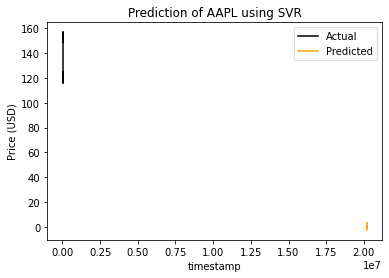

In [529]:
plt.plot(old_test_y.index, old_test_y["result_price"], label = "Actual", color = 'Black')
plt.plot(reverted_predict_y.index, reverted_predict_y, label = "Predicted", color = 'Orange')
plt.xlabel("timestamp")
plt.ylabel("Price (USD)")
plt.title("Prediction of "+stock.upper()+" using SVR")

plt.legend()
plt.savefig("plot/SVR/"+stock.upper()+"-day("+str(num_day_to_predict)+")kernel("+kernel+")C("+str(C)+")gamma("+str(gamma)+")confidence("+str(round(svm_confidence,5))+").jpg",
            dpi=600)
plt.show()




